# Thinc

The central problem for a neural network implementation is this: during the forward pass, you compute results that will later be useful during the backward pass. How do you keep track of this arbitrary state, while making sure that layers can be cleanly composed?

Most libraries solve this problem by having you declare the forward computations, which are then compiled into a graph somewhere behind the scenes. Thinc doesn't have a "computational graph". Instead, we just use the stack, because we put the state from the forward pass into callbacks.

https://github.com/explosion/thinc

All nodes in the network have a simple signature:

``` python
f(inputs) -> {outputs, f(d_outputs)->d_inputs}
```


In [1]:
import numpy as np
import logging
logging.basicConfig(filename='debug.log',level=logging.DEBUG)

## Activations

In [2]:
def relu(inputs):
    mask = inputs > 0
    def backprop_relu(d_outputs, optimizer, **kwargs):
        return d_outputs * mask
    return inputs * mask, backprop_relu

## Layers

In [3]:
def create_linear_layer(n_out, n_in):
    W = np.random.randn(n_out, n_in)
    b = np.zeros((n_out, 1))

    def forward(X):
        Y = W @ X + b
        logging.debug("[->]: %s, %s, %s" % (Y.shape, W.shape, b.shape))
        def backward_linear(dY, optimizer, **kwargs):
            logging.debug("[<-]: %d, %d" % dY.shape)
            dX = W.T @ dY
            dW = np.einsum('ik,jk->ij', dY, X)
            db = dY.sum(axis=1, keepdims=True)
           
            optimizer(W, dW)
            optimizer(b, db)

            return dX
        return Y, backward_linear
    return forward

## Utils

In [4]:
def chain(*layers):
    '''
    Chain together layers
    '''
    def forward(X):
        backprops = []
        Y = X
        for layer in layers:
            Y, backprop = layer(Y)
            backprops.append(backprop)
        
        def backward(dY, optimizer, **kwargs):
            for backprop in reversed(backprops):
                dY = backprop(dY, optimizer, **kwargs)
            return dY
        
        return Y, backward
    
    return forward

## Optimizer

In [5]:
def sgd(theta, dtheta, alpha = 0.001):
    theta -= alpha * dtheta

## Cost

In [6]:
def create_mse_layer():
    def forward(X):
        cost = lambda y: np.average((X - y)**2)
        
        def backward_mse(dY, optimizer, y):
            dX = -2 * (y - X)
            return dX
        
        return cost, backward_mse
    
    return forward

## Train

In [7]:
def train(X, y, model, optimizer, epochs = 10):    
    for i in range(epochs):
        cost, backpropagate = model(X)
        backpropagate(1, sgd, y = y)

        yield i, cost(y)

## Sample data

In [8]:
def data(N, features_num, m=3):
    X = np.random.randn(features_num, N)
    W1 = np.random.randn(m, features_num)
    W2 = np.random.randn(1, m)

    y = W1 @ X
    y = W2 @ (y *(y > 0))
    
    return  X, y

## Model example

In [9]:
EPOCHS = 10
NUM_EXAMPLES = 100
NUM_FEATURES = 5

X, y = data(NUM_EXAMPLES, NUM_FEATURES)

In [10]:
affine_1 = create_linear_layer(3, 5)
affine_2 = create_linear_layer(1, 3)
mse = create_mse_layer()

mlp = chain(affine_1, relu, affine_2, mse)

In [11]:
costs = [(i, c) for (i, c) in train(
    X, y,
    epochs = EPOCHS, 
    model = mlp,
    optimizer = sgd
)] 


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
xs, ys = zip(*costs)

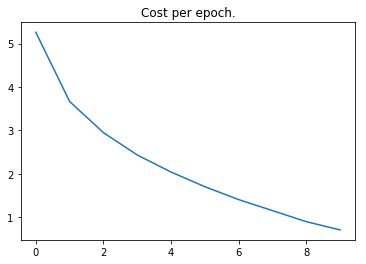

In [14]:
plt.title("Cost per epoch.")
plt.plot(xs, ys);

## Model

Now we will show, how can we implement operator overloading with context manager to be able to specify our model in a following manner:

```python
with Model.define_operators({">>": chain_models}):
    model = (Input(100, 5)
        >> Affine(3, 5)
        >> ReLu() 
        >> Affine(1, 3) 
        >> MSE()
    )
```

In [15]:
import contextlib

In [16]:
class Model(object):
    _operators = {}
    
    def __rshift__(self, other):
        '''Apply the function bound to the '>>' operator.'''
        return self._operators['>>'](self, other)
    
    @classmethod
    @contextlib.contextmanager
    def define_operators(cls, operators):
        old_ops = dict(cls._operators)
        for op, func in operators.items():
            cls._operators[op] = func
        yield
        cls._operators = old_ops
        
    def __call__(self, X):
        return self.forward(X)

In [17]:
class Affine(Model):
    def __init__(self, n_out, n_in):
        self.forward = create_linear_layer(n_out, n_in) 

class ReLu(Model):
    def __init__(self):
        self.forward = relu
    
class MSE(Model):
    def __init__(self):
        self.forward = create_mse_layer()
        
class FeedForward(Model):
    def __init__(self, layers):
        self._layers = []
        for layer in layers:
            if isinstance(layer, FeedForward):
                self._layers.extend(layer._layers)
            else:
                self._layers.append(layer)
    
    def __call__(self):
        '''
        Chain together layers
        '''
        def forward(X):
            backprops = []
            Y = X
            for layer in self._layers:
                Y, backprop = layer(Y)
                backprops.append(backprop)

            def backward(dY, optimizer, **kwargs):
                for backprop in reversed(backprops):
                    dY = backprop(dY, optimizer, **kwargs)
                return dY

            return Y, backward
    
        return forward

class Input(Model):
    def __init__(self, n_in, n_out):
        self.forward = Input.create_identity(n_in, n_out)
        
    @classmethod  
    def create_identity(self, n_in, n_out):
        def forward(X):
            def backward_id(dY, optimizer, **kwargs):
                logging.debug("[<-]: %d, %d" % dY.shape)
                return np.ones((n_in, n_out))

            return X, backward_id
    
        return forward

def chain_models(*layers):
    if len(layers) == 0:
        return FeedForward([])
    elif len(layers) == 1:
        return layers[0]
    else:
        return FeedForward(layers)

In [18]:
with Model.define_operators({">>": chain_models}):
    model = (Input(100, 5)
        >> Affine(3, 5)
        >> ReLu() 
        >> Affine(1, 3) 
        >> MSE()
    )

In [19]:
costs = [(i, c) for (i, c) in train(
    X, y,
    epochs = EPOCHS, 
    model = model(),
    optimizer = sgd
)] 


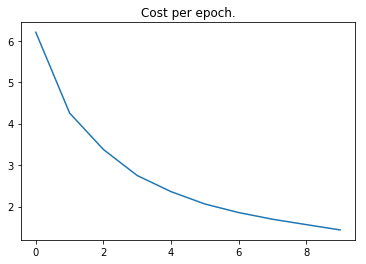

In [20]:
xs, ys = zip(*costs)
plt.title("Cost per epoch.")
plt.plot(xs, ys);